In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.widgets import Slider
from scipy.optimize import curve_fit

import ipywidgets as widgets
from ipywidgets import interact, FloatSlider, Output, RadioButtons

from numpy.polynomial import Chebyshev

from scipy.special import erf

# Workflow for Color Fringe Computation and Chromatic Correction
This document outlines the steps needed to simulate chromatic aberration effects, including data import, interpolation, interactive curve fitting, and analysis of color fringe width. The simulation takes into account the physics of chromatic aberration, sensor response, and overexposure effects.

**this is the backup version 1.1**

## 1. Data Import

### 1.1 Import Defocus-Wavelength Data

#### Objective
Import Zemax defocus data for wavelengths from 400 nm to 700 nm to model longitudinal chromatic aberration in an optical system.

#### Details
The data is stored in a NumPy array where each row contains two values: the wavelength (nm) and the corresponding defocus (µm).

In [23]:
# CHLzf85 data points
# Each row contains [wavelength (nm), defocus (µm)]
CHLzf85 = np.array([
    [400.0, 285.0],
    [410.0, 190.0],
    [420.0, 118.0],
    [430.0, 63.0],
    [440.0, 22.0],
    [450.0, -9.0],
    [460.0, -31.0],
    [470.0, -46.0],
    [480.0, -56.0],
    [490.0, -62.0],
    [500.0, -64.0],
    [510.0, -63.0],
    [520.0, -60.0],
    [530.0, -54.0],
    [540.0, -48.0],
    [550.0, -39.0],
    [560.0, -30.0],
    [570.0, -20.0],
    [580.0, -9.0],
    [590.0, 3.0],
    [600.0, 15.0],
    [610.0, 28.0],
    [620.0, 41.0],
    [630.0, 54.0],
    [640.0, 68.0],
    [650.0, 82.0],
    [660.0, 96.0],
    [670.0, 111.0],
    [680.0, 125.0],
    [690.0, 139.0],
    [700.0, 156.0]
])

### 1.2 Import Sensor and Light Source Data

#### Objective
Load additional spectral data for optical imaging analysis.

#### Details
These spectra define the effective weighting of each wavelength in imaging, as the final image intensity is determined by the sensor response, light source, and optical transmission. For evaluating chromatic aberrations, the weighting spectrum for each color channel $ i $ ($ R $, $ G $, or $ B $) is defined as:

$$
g_i(\lambda) = s_i(\lambda) \cdot q(\lambda) \cdot t(\lambda)
$$

Where:
- $s_i(\lambda)$ is the spectral sensor response for channel \( i \).
- $q(\lambda)$ is the spectral source distribution.
- $t(\lambda)$ is the lens transmission, here assumed to be 1.

The weighting function is normalized for each channel:

$$
\int g_i(\lambda) \, d\lambda = 1 \quad \text{for } i = R, G, B
$$

Normalization ensures that overall intensity is preserved when contributions from all wavelengths are combined.

In [37]:
# Light Source Data
# Each row contains [wavelength (nm), daylight value]
or_Daylight = np.array([
    [380, 11],
    [390, 16],
    [400, 22],
    [410, 33],
    [420, 48],
    [430, 62],
    [440, 71],
    [450, 78],
    [460, 84],
    [470, 92],
    [480, 97],
    [490, 100],
    [500, 96],
    [510, 95],
    [520, 95],
    [530, 94],
    [540, 90],
    [550, 78],
    [560, 70],
    [570, 78],
    [580, 88],
    [590, 94],
    [600, 91],
    [610, 85],
    [620, 82],
    [630, 85],
    [640, 92],
    [650, 100],
    [660, 89],
    [670, 76],
    [680, 83],
    [690, 100]
])

# Optional: Print the shape and first few rows for verification
print("Original Daylight Spectrum shape:", or_Daylight.shape)

Original Daylight Spectrum shape: (32, 2)


In [4]:
# Sensor data for each channel:
# Each row contains [wavelength (nm), sensitivity]
SensorBlue = np.array([
    [400., 0.42],
    [410., 9.08],
    [420., 24.34],
    [430., 28.37],
    [440., 40.12],
    [450., 39.01],
    [460., 47.12],
    [470., 46.65],
    [480., 41.14],
    [490., 26.73],
    [500., 14.75],
    [510., 7.55],
    [520., 2.76],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 0.],
    [580., 0.],
    [590., 0.],
    [600., 0.],
    [610., 0.],
    [620., 0.],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.84],
    [680., 0.32],
    [690., 0.04],
    [700., 0.]
])

SensorGreen = np.array([
    [400., 0.],
    [410., 0.],
    [420., 0.],
    [430., 0.],
    [440., 0.],
    [450., 0.],
    [460., 0.],
    [470., 4.63],
    [480., 6.48],
    [490., 9.09],
    [500., 17.75],
    [510., 28.39],
    [520., 37.8],
    [530., 38.39],
    [540., 35.02],
    [550., 28.83],
    [560., 28.1],
    [570., 19.02],
    [580., 13.1],
    [590., 6.96],
    [600., 4.33],
    [610., 3.34],
    [620., 3.02],
    [630., 0.],
    [640., 0.],
    [650., 0.],
    [660., 0.69],
    [670., 0.7],
    [680., 0.34],
    [690., 0.05],
    [700., 0.]
])

SensorRed = np.array([
    [400., 0.],
    [410., 1.3],
    [420., 1.86],
    [430., 2.17],
    [440., 1.73],
    [450., 0.],
    [460., 0.],
    [470., 0.],
    [480., 0.],
    [490., 0.],
    [500., 0.],
    [510., 0.],
    [520., 0.],
    [530., 0.],
    [540., 0.],
    [550., 0.],
    [560., 0.],
    [570., 2.38],
    [580., 60.18],
    [590., 100.],
    [600., 92.73],
    [610., 72.75],
    [620., 50.6],
    [630., 35.81],
    [640., 35.08],
    [650., 22.4],
    [660., 16.96],
    [670., 7.75],
    [680., 3.3],
    [690., 0.78],
    [700., 0.18]
])

# Optional: Print sensor data shapes to confirm successful import
print("SensorBlue shape:", SensorBlue.shape)
print("SensorGreen shape:", SensorGreen.shape)
print("SensorRed shape:", SensorRed.shape)

SensorBlue shape: (31, 2)
SensorGreen shape: (31, 2)
SensorRed shape: (31, 2)


Although individual channel data (Blue, Green, and Red) provide the spectral sensitivity for each color separately, sensor total data represents the overall sensor response when all channels are combined. This composite measurement is essential for calibrating and fitting the individual channel models, ensuring that their combined output accurately reproduces the total sensor response and that the final image intensity reflects the true behavior of the sensor.

In [5]:
# SensorTotal data for fitting:
# Each row contains [wavelength (nm), total sensor response value]
SensorTotal = np.array([
    [400, 0.00575498651873479],
    [410, 0.13598725582740515],
    [420, 0.3500690684259469],
    [430, 0.40804851719416124],
    [440, 0.5651351405209354],
    [450, 0.5345286287996289],
    [460, 0.6456546780066269],
    [470, 0.7123935338849308],
    [480, 0.6661335648527817],
    [490, 0.509934788098398],
    [500, 0.48265533396893734],
    [510, 0.5521677813325649],
    [520, 0.6352622586348873],
    [530, 0.6067689564250143],
    [540, 0.553504789111852],
    [550, 0.45566941947728984],
    [560, 0.44413148412458714],
    [570, 0.3218004034152092],
    [580, 0.7426492984019468],
    [590, 1.0],
    [600, 0.8937292232977762],
    [610, 0.7002609893330851],
    [620, 0.4980694870649698],
    [630, 0.31870702306489324],
    [640, 0.3122100633654413],
    [650, 0.19935876338044142],
    [660, 0.17130340412862252],
    [670, 0.09154831881506421],
    [680, 0.03912840235676034],
    [690, 0.008280320438011262],
    [700, 0.0016019900628785474]
])
# Optional: Print the shape and first few rows to confirm successful import
print("SensorTotal shape:", SensorTotal.shape)

SensorTotal shape: (31, 2)


## 2. Data Fitting and Common Sampling Scheme

### 2.1 Interpolation onto a Common Scheme

#### Objective
Align all datasets onto the same wavelength grid.

#### Details
The Zemax defocus data, sensor sensitivity, and light source spectrum must be interpolated or fitted to a common sampling scheme. Based on the sensor's spectral range (400 to 700 nm), we fit the defocus data and rearrange the light source spectrum onto this same grid by first fitting the available data and then resampling. This ensures consistency across all datasets for subsequent calculations.

#### 1. Fitting CHL Data
Fit a 6th-degree polynomial to the CHL data, which quantifies the longitudinal chromatic aberration of the lens.

In [6]:
# CHL fit: polynomial of degree 6

# x_CHL contains the wavelength values and y_CHL the corresponding CHL values from the dataset CHLzf85.
x_CHL = CHLzf85[:, 0]
y_CHL = CHLzf85[:, 1]

# Fit a 6th-degree polynomial to the CHL data
CHL_coeffs = np.polyfit(x_CHL, y_CHL, 6)

# Define a function to evaluate the fitted polynomial at any given x (wavelength)
def CHLFit(x):
    # np.polyval evaluates the polynomial for the input x using coefficients in descending order
    return np.polyval(CHL_coeffs, x)

# Optional: Print the coefficients for inspection
print("Fitted CHL coefficients:", CHL_coeffs)

Fitted CHL coefficients: [ 6.17055255e-12 -2.17284405e-08  3.18690992e-05 -2.49424071e-02
  1.09994225e+01 -2.59404221e+03  2.55683162e+05]


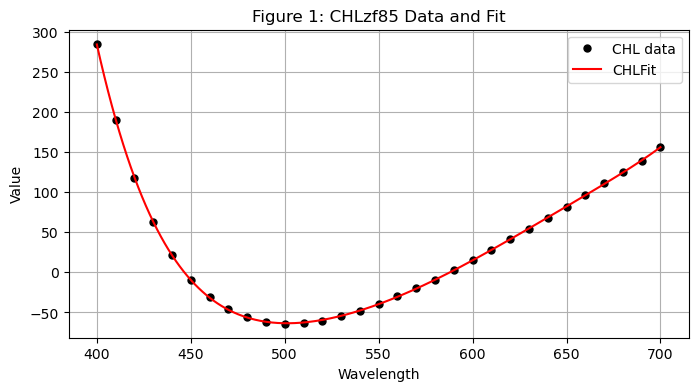

In [25]:
# Figure 1: CHLzf85 plot (points and line)
plt.figure(figsize=(8, 4))
plt.plot(x_CHL, y_CHL, 'o', markersize=5, color='black', label='CHL data') # Points in black
x_fit = np.linspace(400, 700, 300)
plt.plot(x_fit, CHLFit(x_fit), '-', color='red', label='CHLFit') # Curve in red
plt.title('Figure 1: CHLzf85 Data and Fit')
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

#### 2. Fitting Light Source Data
Fit the light source spectrum data to a smooth function that can be easily interpolated and resampled on a common wavelength grid.

In [38]:
# Light Source Fit: polynomial of degree 6 and resampling

def resample_spectrum_poly(spectrum, new_wavelengths, degree=6):
    # Separate the wavelength and intensity data
    wavelengths = spectrum[:, 0]
    intensities = spectrum[:, 1]
    
    # Fit a polynomial of the given degree to the data
    coeffs = np.polyfit(wavelengths, intensities, degree)
    poly_func = np.poly1d(coeffs)
    
    # Evaluate the polynomial at the new wavelengths
    new_intensities = poly_func(new_wavelengths)
    
    return np.column_stack((new_wavelengths, new_intensities))

# Resample the spectrum using a 6th-degree polynomial fit
Daylight = resample_spectrum_poly(or_Daylight, x_CHL, degree=6)

# Print the resampled spectrum
print("Resampled Daylight Spectrum:")
print(Daylight)

Resampled Daylight Spectrum:
[[400.          21.03530862]
 [410.          33.00434804]
 [420.          46.64413764]
 [430.          60.06933007]
 [440.          72.02371976]
 [450.          81.7674974 ]
 [460.          88.97373132]
 [470.          93.63407586]
 [480.          95.97370662]
 [490.          96.3754827 ]
 [500.          95.31333583]
 [510.          93.29488646]
 [520.          90.81328676]
 [530.          88.30829058]
 [540.          86.13655031]
 [550.          84.55114072]
 [560.          83.69030971]
 [570.          83.57545596]
 [580.          84.1183336 ]
 [590.          85.13748369]
 [600.          86.38389279]
 [610.          87.57587832]
 [620.          88.44320092]
 [630.          88.78040376]
 [640.          88.50937874]
 [650.          87.75115967]
 [660.          86.90694232]
 [670.          86.74833149]
 [680.          88.51681492]
 [690.          94.03246423]
 [700.         105.81186271]]


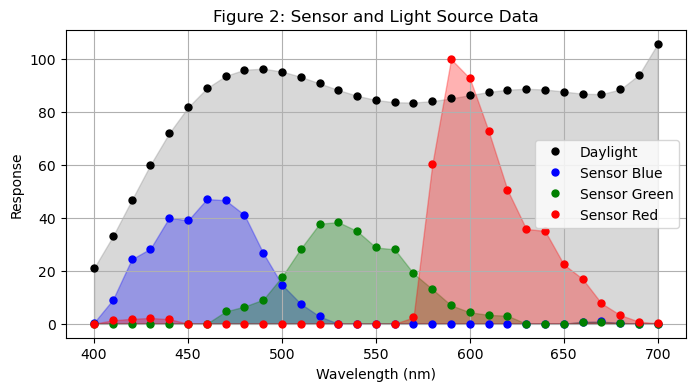

In [40]:
# Figure 2: Sensor response and light source spectrum (points and line)

plt.figure(figsize=(8, 4))

# Plot the Daylight spectrum (assumed to be stored in the 'Daylight' variable)
# 'o' markers are used for the data points, with black color.
plt.plot(Daylight[:,0], Daylight[:,1], 'o', markersize=5, color='black', label='Daylight')
# Fill the area under the Daylight curve with a light gray color
plt.fill_between(Daylight[:,0], Daylight[:,1], color='gray', alpha=0.3)

# Plot the Sensor Blue data using blue markers and line
plt.plot(SensorBlue[:,0], SensorBlue[:,1], 'o', markersize=5, color='blue', label='Sensor Blue')
# Fill the area under the Sensor Blue curve with a blue color
plt.fill_between(SensorBlue[:,0], SensorBlue[:,1], color='blue', alpha=0.3)

# Plot the Sensor Green data using green markers and line
plt.plot(SensorGreen[:,0], SensorGreen[:,1], 'o', markersize=5, color='green', label='Sensor Green')
# Fill the area under the Sensor Green curve with a green color
plt.fill_between(SensorGreen[:,0], SensorGreen[:,1], color='green', alpha=0.3)

# Plot the Sensor Red data using red markers and line
plt.plot(SensorRed[:,0], SensorRed[:,1], 'o', markersize=5, color='red', label='Sensor Red')
# Fill the area under the Sensor Red curve with a red color
plt.fill_between(SensorRed[:,0], SensorRed[:,1], color='red', alpha=0.3)

plt.title('Figure 2: Sensor and Light Source Data')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Response')
plt.legend()
plt.grid(True)
plt.show()

#### 3. NSensorFit Using Chebyshev Polynomials

- **Objective:**  
  Fit the overall sensor response (SensorTotal) using a Chebyshev polynomial of degree 12.

- **Details:**  
  - The SensorTotal data, which represents the composite sensor response, is fitted using Chebyshev polynomials.  
  - Chebyshev polynomials are chosen for their numerical stability and ability to accurately capture the underlying trends in the sensor data.  
  - A degree 12 polynomial provides a balance between capturing the details in the sensor's response and avoiding overfitting.  
  - This smooth, stable fit is essential for subsequent simulations, as it ensures that integrations over wavelength are accurate and free from numerical artifacts.

- **Physics Note:**  
  The sensor’s total spectral response is critical for accurately modeling how the incoming light—weighted by the sensor’s sensitivity—converts to an image signal. A reliable polynomial fit facilitates proper spectral integration, ultimately leading to more accurate simulations of image formation and chromatic aberration effects.

In [9]:
# Extract wavelengths and corresponding sensor response values from SensorTotal data
x_sensor = SensorTotal[:, 0]
y_sensor = SensorTotal[:, 1]

# Fit a Chebyshev polynomial of degree 12 to the SensorTotal data.
# Chebyshev polynomials are used for their numerical stability and efficiency in approximating functions.
cheb_fit = Chebyshev.fit(x_sensor, y_sensor, 12)

def NSensorFit(x):
    """
    Evaluate the Chebyshev polynomial fit on SensorTotal data at the given wavelengths.
    
    Parameters:
        x (array-like): Wavelength values (in nm) at which to evaluate the sensor response.
    
    Returns:
        array-like: The corresponding sensor response values as predicted by the Chebyshev fit.
    """
    return cheb_fit(x)

# Optional: Print the fitted Chebyshev coefficients for inspection
print("Chebyshev polynomial fit coefficients:", cheb_fit.coef)

Chebyshev polynomial fit coefficients: [ 0.34510157 -0.11515904 -0.31924981  0.02426869 -0.04072533  0.09656001
  0.05035412 -0.05459439 -0.04298552  0.00747738  0.04597954  0.05036164
 -0.03743578]


#### 4. SensorFit with Custom Basis Functions

- **Objective:**  
  Model the sensor response using a custom set of basis functions that combine polynomial terms with an exponential component.

- **Details:**  
  - Instead of using a standard polynomial fit, this approach employs a custom basis that incorporates both polynomial terms (to capture the broad trend) and an exponential term.
  - The polynomial part effectively captures the overall trend of the sensor response.
  - The exponential term is included to accurately model specific features, such as the peak near 550 nm—a common characteristic in many digital sensors.
  - This detailed fitting strategy is crucial for precisely modeling the sensor’s response, which directly affects the spectral weighting \( g_i(\lambda) \) used in the imaging model.

- **Physics Note:**  
  A precise sensor response model is critical because it influences how the incoming light (weighted by the sensor’s sensitivity) is converted into an image signal. By capturing both the general trend and specific features of the sensor response, the custom basis function fit ensures that simulated intensity distributions and resulting color fringe effects are accurately reproduced in the imaging simulation.

### 2.2. Normalization and Combination

Blue channel integrated value: 1.0
Green channel integrated value: 0.9999999999999999
Red channel integrated value: 1.0


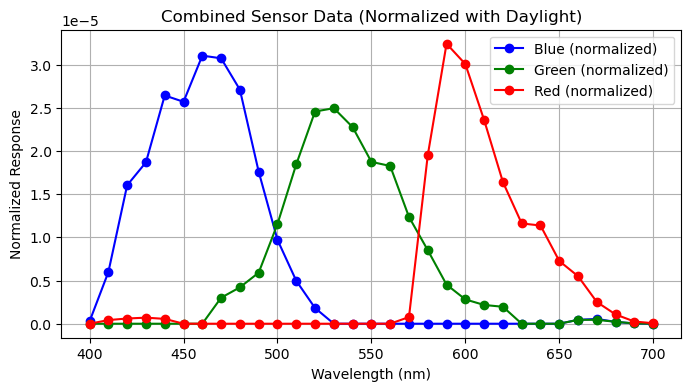

In [11]:
# Compute the normalization factor for each sensor channel.
# Here, we assume:
# - Sensor[:, 0] contains wavelength (λ)
# - Sensor[:, 1] contains the sensor response
# - Daylight[:, 0] contains the daylight intensity at those wavelengths.
blue_norm_factor = np.trapezoid(SensorBlue[:, 1] * Daylight[:, 0], SensorBlue[:, 0])
green_norm_factor = np.trapezoid(SensorGreen[:, 1] * Daylight[:, 0], SensorGreen[:, 0])
red_norm_factor = np.trapezoid(SensorRed[:, 1] * Daylight[:, 0], SensorRed[:, 0])

# Normalize sensor responses so that:
# ∫ [Sensor_channel(λ) * DaylightIntensity(λ)] dλ = 1 for each channel.
norm_blue = SensorBlue[:, 1] / blue_norm_factor
norm_green = SensorGreen[:, 1] / green_norm_factor
norm_red = SensorRed[:, 1] / red_norm_factor

# Verify that each channel is normalized:
blue_integral = np.trapezoid(norm_blue * Daylight[:, 0], SensorBlue[:, 0])
green_integral = np.trapezoid(norm_green * Daylight[:, 0], SensorGreen[:, 0])
red_integral = np.trapezoid(norm_red * Daylight[:, 0], SensorRed[:, 0])

print("Blue channel integrated value:", blue_integral)
print("Green channel integrated value:", green_integral)
print("Red channel integrated value:", red_integral)

# ---------------------------
# Final Combined Sensor Plot (overlaid) with Normalization
# ---------------------------
plt.figure(figsize=(8, 4))

plt.plot(SensorBlue[:, 0], norm_blue, 'o-', color='blue', label='Blue (normalized)')
plt.plot(SensorGreen[:, 0], norm_green, 'o-', color='green', label='Green (normalized)')
plt.plot(SensorRed[:, 0], norm_red, 'o-', color='red', label='Red (normalized)')

plt.title('Combined Sensor Data (Normalized with Daylight)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Response')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def process_channels(norm_blue, norm_green, norm_red, start=400, stop=701, step=10):
    # Generate the wavelength array
    wavelengths = np.arange(start, stop, step)
    # Combine wavelengths and channel data into 2D arrays without rounding
    blue  = np.column_stack((wavelengths, norm_blue))
    green = np.column_stack((wavelengths, norm_green))
    red   = np.column_stack((wavelengths, norm_red))
    return blue, green, red

    # Process the channels
SensorBlue_norm, SensorGreen_norm, SensorRed_norm = process_channels(norm_blue, norm_green, norm_red)

print("Blue channel:\n", SensorBlue_norm)
print("\nGreen channel:\n", SensorGreen_norm)
print("\nRed channel:\n", SensorRed_norm)

Blue channel:
 [[4.00000000e+02 2.76669453e-07]
 [4.10000000e+02 5.98133008e-06]
 [4.20000000e+02 1.60336535e-05]
 [4.30000000e+02 1.86883628e-05]
 [4.40000000e+02 2.64285201e-05]
 [4.50000000e+02 2.56973223e-05]
 [4.60000000e+02 3.10396777e-05]
 [4.70000000e+02 3.07300714e-05]
 [4.80000000e+02 2.71004317e-05]
 [4.90000000e+02 1.76080345e-05]
 [5.00000000e+02 9.71636770e-06]
 [5.10000000e+02 4.97346279e-06]
 [5.20000000e+02 1.81811355e-06]
 [5.30000000e+02 0.00000000e+00]
 [5.40000000e+02 0.00000000e+00]
 [5.50000000e+02 0.00000000e+00]
 [5.60000000e+02 0.00000000e+00]
 [5.70000000e+02 0.00000000e+00]
 [5.80000000e+02 0.00000000e+00]
 [5.90000000e+02 0.00000000e+00]
 [6.00000000e+02 0.00000000e+00]
 [6.10000000e+02 0.00000000e+00]
 [6.20000000e+02 0.00000000e+00]
 [6.30000000e+02 0.00000000e+00]
 [6.40000000e+02 0.00000000e+00]
 [6.50000000e+02 0.00000000e+00]
 [6.60000000e+02 4.54528387e-07]
 [6.70000000e+02 5.53338906e-07]
 [6.80000000e+02 2.10795774e-07]
 [6.90000000e+02 2.63494717e

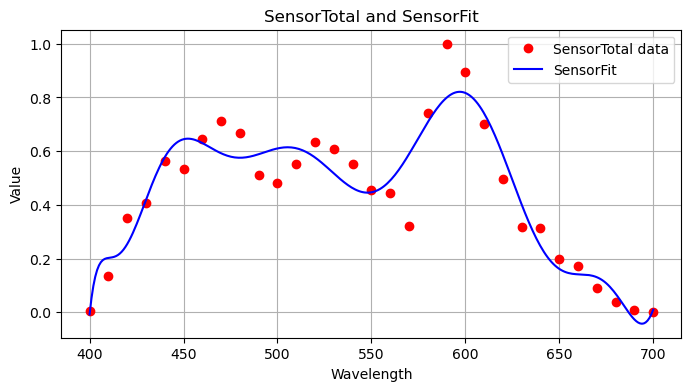

In [13]:
# ---------------------------
# Additional Fit Plots
# ---------------------------
# Plot SensorTotal with SensorFit
plt.figure(figsize=(8, 4))
plt.plot(x_sensor, y_sensor, 'o', color='red', label='SensorTotal data')
plt.plot(x_fit, NSensorFit(x_fit), '-', color='blue', label='SensorFit')
plt.title('SensorTotal and SensorFit')
plt.xlabel('Wavelength')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

### 2.3. CHL Curve Modification

- **Objective:**  
  Enable dynamic adjustments of the fitted CHL curve.

- **Details:**  
  - Incorporate interactive sliders to adjust the *shift* (a uniform displacement) and *tilt* (a slope variation across the aperture) of the CHL curve.
  - These adjustments allow you to simulate variations in the defocus behavior and fine-tune the fitted curve to match real-world conditions.
  - The interactive elements provide a means to visualize the effects of misalignment or decentration on the longitudinal chromatic aberration.

- **Physics Note:**  
  The shift and tilt parameters simulate practical imperfections such as misalignment or lens element decentration, which can alter the focus across the field. By dynamically modifying these parameters, you can explore how these real-world factors influence the CHL curve and, consequently, the resulting image quality and color fringing.


In [14]:
# Compute the original lowest point on 400–700 nm (assuming CHLFit is defined)
x_plot = np.linspace(400, 700, 300)
base_vals = CHLFit(x_plot)
x_min = x_plot[np.argmin(base_vals)]
y_min = np.min(base_vals)
print("Original lowest point at x = {:.2f} nm, y = {:.2f}".format(x_min, y_min))

# Define the wavelength range for plotting.
x_vals = np.linspace(400, 700, 300)
dx = x_vals[1] - x_vals[0]

def CHLFit_mod(x_vals, x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Returns the modified CHL curve with preserved monotonicity by scaling the derivative.
    
    The procedure is:
      1. Define the pivot: pivot_x = x_min + x_shift, and pivot_y = CHLFit(x_min).
      2. Evaluate the base curve at shifted x-values: f(x) = CHLFit(x - x_shift).
      3. Compute its numerical derivative.
      4. Multiply the derivative by (1 + tilt_left) for x < pivot_x and by (1 + tilt_right) for x >= pivot_x.
      5. Integrate the new derivative (with g(pivot)=pivot_y) to construct the modified curve.
      
    This guarantees that if (1 + tilt) > 0 on both sides, the sign of the derivative remains unchanged.
    """
    # Define pivot (using original x_min for the base function)
    pivot_x = x_min + x_shift
    pivot_y = CHLFit(x_min)
    
    # Compute the horizontally shifted base curve.
    # Note: We assume CHLFit accepts a numpy array.
    x_shifted = x_vals - x_shift
    base = CHLFit(x_shifted)
    
    # Compute numerical derivative of the base curve.
    dbase = np.gradient(base, dx)
    
    # Determine the scaling factor for the derivative on each side.
    factor = np.where(x_vals < pivot_x, 1 + tilt_left, 1 + tilt_right)
    new_deriv = dbase * factor
    
    # Integrate the new derivative to construct the modified curve.
    g = np.empty_like(x_vals)
    # Find the index of the pivot (closest to pivot_x)
    pivot_index = np.argmin(np.abs(x_vals - pivot_x))
    g[pivot_index] = pivot_y
    
    # Integrate forward from the pivot.
    for i in range(pivot_index + 1, len(x_vals)):
        g[i] = g[i - 1] + new_deriv[i - 1] * dx
    # Integrate backward from the pivot.
    for i in range(pivot_index - 1, -1, -1):
        g[i] = g[i + 1] - new_deriv[i + 1] * dx
        
    return g

def plot_CHL(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Plots the modified CHL curve, with a multiplicative tilt applied to the derivative.
    
    Use tilt_left and tilt_right (both must be > -1) to adjust the slopes on the left and right,
    and x_shift to shift the base curve horizontally.
    """
    y_vals = CHLFit_mod(x_vals, x_shift, tilt_left, tilt_right)
    
    plt.figure(figsize=(8, 4))
    plt.plot(x_vals, y_vals, label='Modified CHL Curve', lw=2)
    plt.scatter(x_CHL, y_CHL, color='red', label='Data Points')
    plt.scatter([x_min], [y_min], color='green', s=100, label='Original Lowest Point')
    plt.scatter([x_min + x_shift], [CHLFit(x_min)], color='blue', s=100, label='Shifted Pivot')
    
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('CHL Value')
    plt.title('CHL Curve with x-axis Shift and Tilt Preserving Monotonicity')
    plt.legend()
    plt.grid(True)
    plt.xlim(400, 700)
    plt.show()

def extract_modified_curve_values(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Extracts the y-values of the modified CHL curve at x_vals (400~700 nm) based on the given parameters,
    and returns only their integer parts (using np.floor to round down).
    """
    y_modified = CHLFit_mod(x_vals, x_shift, tilt_left, tilt_right)
    y_modified_int = np.floor(y_modified)
    return y_modified_int

def extract_sampled_modified_values(x_shift=0.0, tilt_left=0.0, tilt_right=0.0):
    """
    Extracts the modified CHL curve from 400 to 700 nm (with one sample every 10 nm),
    and returns a 2-column matrix where the first column is the wavelength and the second column is the integer part of the CHL value.
    """
    x_sample = np.arange(400, 701, 10)
    y_sample = CHLFit_mod(x_sample, x_shift, tilt_left, tilt_right)
    y_sample_int = np.floor(y_sample)
    # Merge into a 2D array, each row [wavelength, CHL value]
    return np.column_stack((x_sample, y_sample_int))

# Define a global variable to store the matrix extracted after interactive updates
global_modified_curve = None
global_extracted_values = None

# Define interactive sliders
x_shift_slider = FloatSlider(min=-50, max=50, step=1, value=0, description='x Shift (nm)')
tilt_left_slider = FloatSlider(min=-0.9, max=1.0, step=0.01, value=0, description='Tilt Left')
tilt_right_slider = FloatSlider(min=-0.9, max=1.0, step=0.01, value=0, description='Tilt Right')

# Use an Output area for updating display
out = Output()

def update_all(x_shift, tilt_left, tilt_right):
    global global_modified_curve, global_CHLfit
    with out:
        out.clear_output(wait=True)
        # Plot the modified curve
        plot_CHL(x_shift, tilt_left, tilt_right)
        # Global save the sampled data on the curve
        global_CHLfit = extract_sampled_modified_values(x_shift, tilt_left, tilt_right)
        # Global save the modified curve
        global_modified_curve = CHLFit_mod(x_vals, x_shift, tilt_left, tilt_right)
        print("Modified CHLzf85 = np.array(")
        
        print(global_CHLfit.tolist())
        print(")")
        print("global_modified_curve shape:", global_modified_curve.shape)
        
# Create the interactive interface
interact(update_all, 
         x_shift=x_shift_slider, 
         tilt_left=tilt_left_slider, 
         tilt_right=tilt_right_slider)

display(out)




Original lowest point at x = 501.34 nm, y = -63.42


interactive(children=(FloatSlider(value=0.0, description='x Shift (nm)', max=50.0, min=-50.0, step=1.0), Float…

Output()

In [15]:
def wavelength_to_rgb(wavelength, gamma=0.8):
    """
    Convert a given wavelength in nm to an RGB color.
    Based on the algorithm from Dan Bruton:
    http://www.efg2.com/Lab/ScienceAndEngineering/Spectra.htm
    """
    if 380 <= wavelength < 440:
        attenuation = 0.3 + 0.7*(wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif 440 <= wavelength < 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0 ** gamma
    elif 490 <= wavelength < 510:
        R = 0.0
        G = 1.0 ** gamma
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif 510 <= wavelength < 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0 ** gamma
        B = 0.0
    elif 580 <= wavelength < 645:
        R = 1.0 ** gamma
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif 645 <= wavelength <= 780:
        attenuation = 0.3 + 0.7*(780 - wavelength) / (780 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = G = B = 0.0

    return (R, G, B)

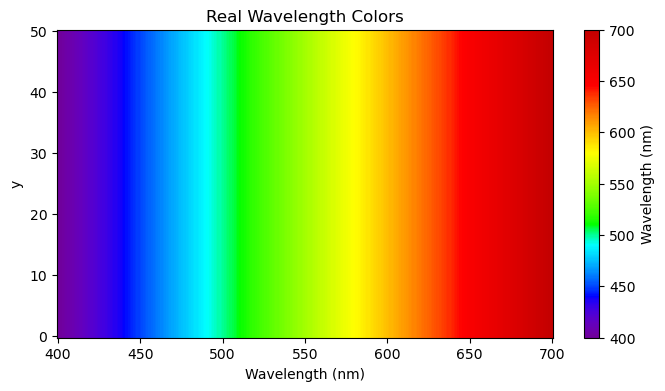

In [16]:
# Create a custom colormap from wavelengths 400 nm to 700 nm.
wavelengths = np.linspace(400, 700, 300)
colors = [wavelength_to_rgb(w) for w in wavelengths]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("wavelength_cmap", colors)

# --- Plot 1: DensityPlot Equivalent ---
# Create the grid and function values.
x_vals = np.linspace(400, 700, 300)
y_vals = np.linspace(0, 50, 100)
X, Y = np.meshgrid(x_vals, y_vals)
Z = X  # f(x,y) = x

plt.figure(figsize=(8, 4))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=custom_cmap)
plt.colorbar(label='Wavelength (nm)')
plt.title('Real Wavelength Colors')
plt.xlabel('Wavelength (nm)')
plt.ylabel('y')
plt.show()

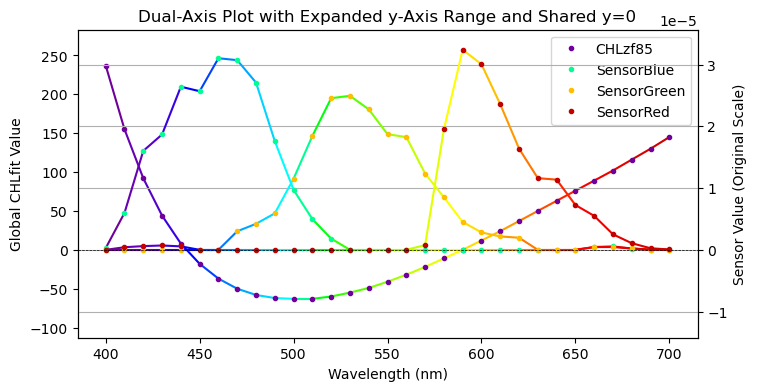

In [17]:
# Original global axis limits:
global_min, global_max = -80, 250
global_range = global_max - global_min
margin_global = 0.1 * global_range  # 10% margin

# Adjusted global limits with margin:
new_global_min = global_min - margin_global
new_global_max = global_max + margin_global

# Compute the fraction where zero lies on the global axis (with margin):
r = (0 - new_global_min) / (new_global_max - new_global_min)

# For sensor data, determine the maximum sensor value (across all sensor datasets).
sensor_max = max(SensorBlue_norm[:, 1].max(), SensorGreen_norm[:, 1].max(), SensorRed_norm[:, 1].max())
# Add a margin to the sensor_max (10% of sensor_max)
sensor_margin = 0.1 * sensor_max
sensor_max_new = sensor_max + sensor_margin

# Compute the sensor lower limit such that 0 lies at the same relative position.
sensor_min_new = - (r / (1 - r)) * sensor_max_new

# Prepare the figure with two y-axes.
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

# Set the y-axis limits:
ax1.set_ylim(new_global_min, new_global_max)
ax2.set_ylim(sensor_min_new, sensor_max_new)

# Plot the global_CHLfit data on the primary axis (ax1).
x_vals = global_CHLfit[:, 0]
y_vals = global_CHLfit[:, 1]
norm = plt.Normalize(400, 700)
colors_mapped = custom_cmap(norm(x_vals))
# Draw the gradient line segments:
for j in range(len(x_vals) - 1):
    ax1.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
# Plot uniform markers:
marker_color = custom_cmap(0 / 3)  # Using index 0 for global_CHLfit
ax1.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label='CHLzf85')

# Plot the sensor datasets on the secondary axis (ax2).
sensor_datasets = [SensorBlue_norm, SensorGreen_norm, SensorRed_norm]
sensor_labels = ['SensorBlue', 'SensorGreen', 'SensorRed']
for i, (sensor, label) in enumerate(zip(sensor_datasets, sensor_labels), start=1):
    x_vals = sensor[:, 0]
    y_vals = sensor[:, 1]
    norm = plt.Normalize(400, 700)
    colors_mapped = custom_cmap(norm(x_vals))
    for j in range(len(x_vals) - 1):
        ax2.plot(x_vals[j:j+2], y_vals[j:j+2], color=colors_mapped[j])
    marker_color = custom_cmap(i / 3)  # Spread markers uniformly over the colormap
    ax2.plot(x_vals, y_vals, 'o', markersize=3, color=marker_color, label=label)

# Add horizontal lines at y=0 on both axes for clarity.
ax1.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')

# Set axis labels.
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Global CHLfit Value')
ax2.set_ylabel('Sensor Value (Original Scale)')

# Combine legends from both axes and position in upper right.
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.title('Dual-Axis Plot with Expanded y-Axis Range and Shared y=0')
plt.grid(True)
plt.show()

In [18]:
# Define parameters
defocusrange = 400
K = 1.4
A = 100
denom = np.sqrt(4*K**2 - 1)
x_vals = np.linspace(400, 700, 300)
def update_plots(z):
    """
    Plots two figures:
      1. Plot of | (z - Modified CHL Curve) / sqrt(4*K^2-1) |.
      2. Plot of the above result multiplied by the curve from SensorFit.
      
    This function uses the global variable 'global_modified_curve' generated from the CHL interactive part.
    
    Parameters:
        z: The defocus parameter (a scalar) that shifts the curve vertically.
    """
    # Check if the global modified curve has been generated
    if global_modified_curve is None:
        print("Please adjust the CHL curve using the slider above first.")
        return

    # Create a subplot with 2 figures side by side
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # First plot: Compute the absolute value of (z - Modified CHL Curve) / denom
    y1 = np.abs((z - global_modified_curve) / denom)
    axs[0].plot(x_vals, y1, '-', color='purple')
    axs[0].fill_between(x_vals, y1, color='purple', alpha=0.3)
    axs[0].set_title(f'| (z - Modified CHL)/sqrt(4*K^2-1) |, z = {z}')
    axs[0].set_xlabel('Wavelength (nm)')
    axs[0].set_ylabel('Value')
    axs[0].set_ylim(0, A)
    axs[0].grid(True)
    
    # Second plot: Multiply the first result by SensorFit evaluated at x_vals
    sensor_fit_vals = NSensorFit(x_vals)
    y2 = y1 * sensor_fit_vals
    axs[1].plot(x_vals, y2, '-', color='orange')
    axs[1].fill_between(x_vals, y2, color='orange', alpha=0.3)
    axs[1].set_title('Multiplied by SensorFit')
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Value')
    axs[1].set_ylim(0, 100)
    axs[1].grid(True)
    
    plt.show()

# Create an interactive slider to adjust the defocus parameter 'z'
interact(update_plots, 
         z=widgets.FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description='defocus'))

# Print shapes for debugging/verification purposes
print("x_vals shape:", x_vals.shape)
print("global_modified_curve shape:", global_modified_curve.shape)
sensor_fit_vals = NSensorFit(x_vals)
print("SensorFit(x_vals) shape:", sensor_fit_vals.shape)

interactive(children=(FloatSlider(value=0.0, description='defocus', max=400.0, min=-400.0, step=1.0), Output()…

x_vals shape: (300,)
global_modified_curve shape: (300,)
SensorFit(x_vals) shape: (300,)


## 3 Overexposure and Color Fringe Focus Calculation

### 3.1 Applying the Overexposure Factor
- Objective: Simulate the effects of overexposure.
- Details:\
    Modify the fitted defocus curve by applying an overexposure factor. Overexposure alters the sensor's opto-electronic conversion function, affecting the intensity distribution.
- Physics Note:\
    Overexposure can enhance or saturate certain parts of the intensity profile, thereby amplifying the visibility of color fringes in the final image.

In [19]:
# CHLdata (active definition)
CHLdata = global_CHLfit[:, 1]

SensorBluedata = SensorBlue_norm[:, 1]
SensorGreendata = SensorGreen_norm[:, 1]
SensorReddata = SensorRed_norm[:, 1]

# Global constant
K = 1.4
# ---------------------------
# Exposure Function
# (Mathematica: Exposure[x_, F_] := Tanh[F*x]/Tanh[F])
# ---------------------------
def Exposure(x, F):
    return np.tanh(F * x) / np.tanh(F)

### 3.2 Calculating Color Fringe Focus with Geometric Model and Gaussian Model
- Objective: Determine the focus differences between color channels.
- Details:\
    Use the modified defocus curve to calculate the color fringe focus, which is the measure of the differential focusing between red, green, and blue channels.
- Physics Note:\
    The resulting color fringes are a direct manifestation of longitudinal chromatic aberration, where different wavelengths converge at different image distances.

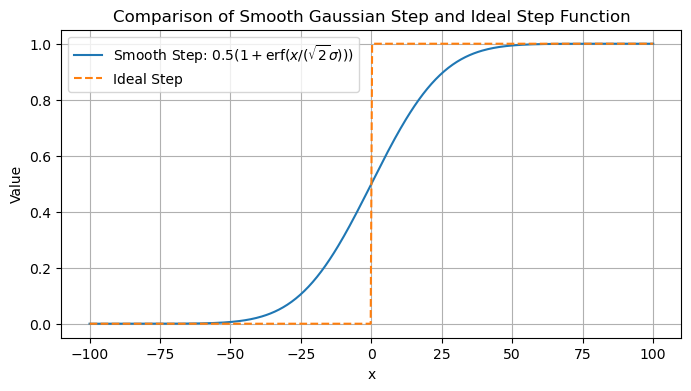

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

# Set sigma for the Gaussian step (controls smoothness)
sigma = 20  # adjust as needed

# Define a range of x values
x = np.linspace(-100, 100, 400)

# Compute the smooth Gaussian step function (cumulative Gaussian)
y_smooth = 0.5 * (1 + erf(x / (np.sqrt(2) * sigma)))

# Define the ideal (hard) step function: 0 for x < 0, 1 for x >= 0
y_step = np.where(x < 0, 0, 1)

# Plot both functions
plt.figure(figsize=(8, 4))
plt.plot(x, y_smooth, label=r'Smooth Step: $0.5(1+\mathrm{erf}(x/(\sqrt{2}\sigma)))$')
plt.plot(x, y_step, label='Ideal Step', linestyle='--')
plt.xlabel("x")
plt.ylabel("Value")
plt.title("Comparison of Smooth Gaussian Step and Ideal Step Function")
plt.legend()
plt.grid(True)
plt.show()


In [21]:
# Global constants and parameters
K = 1.4
xrange_val = 200    # Range for x values in plots
defocusrange = 1000
tol = 0.15

# Assume CHLdata, SensorReddata, SensorGreendata, SensorBluedata are defined globally

# Define the Exposure function
def Exposure(x, F):
    return np.tanh(F * x) / np.tanh(F)

# Define two weighting functions
def ideal_weight(x, ratio):
    """Ideal step function with linear interpolation."""
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    if x >= ratio:
        return 1
    elif x <= -ratio:
        return 0
    else:
        return 0.5 * (1 + x/ratio)

def gaussian_weight(x, ratio):
    """Smooth Gaussian-like step using the error function."""
    if ratio < 1e-6:
        return 1 if x >= 0 else 0
    return 0.5 * (1 + erf(x / (np.sqrt(2) * ratio)))

# Create a generic edge function that works for any sensor channel and weighting
def compute_edge(x, z, F, g, sensor_data, weight_func):
    denom_factor = np.sqrt(4 * K**2 - 1)
    num = 0
    for n in range(len(CHLdata)):
        ratio = abs((z - CHLdata[n]) / denom_factor)
        weight = weight_func(x, ratio)
        num += sensor_data[n] * weight
    den = np.sum(sensor_data)
    return Exposure(num/den, F) ** g

# Define edge functions for each color channel
def EdgeR(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorReddata, weight_func)

def EdgeG(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorGreendata, weight_func)

def EdgeB(x, z, F, g, weight_func):
    return compute_edge(x, z, F, g, SensorBluedata, weight_func)

# Farbsaum and Farbsaumbreite remain unchanged
def Farbsaum(x, z, F, g, weight_func):
    r = EdgeR(x, z, F, g, weight_func)
    g_val = EdgeG(x, z, F, g, weight_func)
    b = EdgeB(x, z, F, g, weight_func)
    if abs(r - b) > tol or abs(r - g_val) > tol or abs(g_val - b) > tol:
        return 1
    return 0

def Farbsaumbreite(z, F, g, weight_func):
    xs = np.arange(-int(np.floor(xrange_val)), int(np.floor(xrange_val))+1)
    return np.sum([Farbsaum(x, z, F, g, weight_func) for x in xs])

# ColorFringe function returns an RGB tuple
def ColorFringe(x, z, F, g, weight_func):
    return (EdgeR(x, z, F, g, weight_func),
            EdgeG(x, z, F, g, weight_func),
            EdgeB(x, z, F, g, weight_func))

# Update plots to allow model comparison
def update_plots(z, F, gamma, model):
    # Select weighting function based on chosen model
    weight_func = ideal_weight if model == 'Ideal Step' else gaussian_weight

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left: plot the 1D edge functions along x
    xs = np.linspace(-xrange_val, xrange_val, 400)
    edgeR_vals = np.array([EdgeR(x, z, F, gamma, weight_func) for x in xs])
    edgeG_vals = np.array([EdgeG(x, z, F, gamma, weight_func) for x in xs])
    edgeB_vals = np.array([EdgeB(x, z, F, gamma, weight_func) for x in xs])
    farb_vals = np.array([Farbsaum(x, z, F, gamma, weight_func) for x in xs])
    
    axs[0].plot(xs, edgeR_vals, color=(1, 0, 0), label='EdgeR')
    axs[0].plot(xs, edgeG_vals, color=(0, 1, 0), label='EdgeG')
    axs[0].plot(xs, edgeB_vals, color=(0, 0, 1), label='EdgeB')
    axs[0].plot(xs, farb_vals, color=(0.2, 0.2, 0.2), label='Farbsaum')
    axs[0].set_title(f"Edge functions ({model} weighting)")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("Response")
    axs[0].set_ylim(0, 1)
    axs[0].legend()
    axs[0].grid(True)
    
    # Right: density plot using ColorFringe (1D slice replicated vertically)
    X = np.linspace(-xrange_val, xrange_val, 200)
    Y = np.linspace(0, 0.5 * xrange_val, 100)
    XX, YY = np.meshgrid(X, Y)
    
    img = np.zeros((YY.shape[0], YY.shape[1], 3))
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            img[i, j, :] = ColorFringe(XX[i, j], z, F, gamma, weight_func)
    img = np.clip(img, 0, 1)
    axs[1].imshow(img, extent=[-xrange_val, xrange_val, 0, 0.5 * xrange_val],
                  aspect='auto')
    axs[1].set_title("Density plot (ColorFringe)")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("y")
    
    plt.tight_layout()
    plt.show()
    
    # Print the computed Farbsaumbreite for current parameters
    print("Farbsaumbreite(z, F, gamma) =", Farbsaumbreite(z, F, gamma, weight_func))

# Create interactive widget to choose parameters and model type
interact(update_plots,
         z=FloatSlider(min=-defocusrange, max=defocusrange, step=1, value=0, description="defocus"),
         F=FloatSlider(min=1, max=16, step=0.1, value=1, description="Exposure F"),
         gamma=FloatSlider(min=0.5, max=4, step=0.1, value=1, description="Gamma"),
         model=RadioButtons(options=['Ideal Step', 'Gaussian Step'], description='Model'));


interactive(children=(FloatSlider(value=0.0, description='defocus', max=1000.0, min=-1000.0, step=1.0), FloatS…

## 4. Through Focus Color Fringe Analysis

### 4.1 Plot Color Fringe Width vs. Defocus Distance
- Objective: Visualize the relationship between defocus and color fringe width.
- Details:\
    Generate a plot showing how the color fringe width varies as a function of defocus distance.
- Physics Note:\
    This plot helps in understanding the impact of defocus on the visibility and extent of color fringes, providing feedback for optical system optimization.

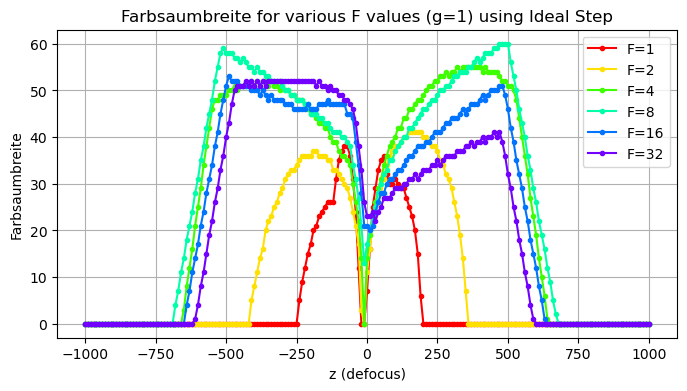

In [22]:
# ---------------------------
# Plotting Farbsaumbreite for different F values
#
# The Mathematica code creates ListPlots of {z, Farbsaumbreite[z,F,1]} for
# F = 1, 2, 4, 8, 16, 32 with dd = 10 and displays them overlaid.
# ---------------------------
dd = 10
z_vals = np.arange(-defocusrange, defocusrange + 1, dd)

def plot_farbs(F_value, label, hue, weight_func):
    # Compute list of (z, Farbsaumbreite[z, F, 1]) using the specified weight function.
    data = np.array([[z, Farbsaumbreite(z, F_value, 1, weight_func)] for z in z_vals])
    plt.plot(data[:, 0], data[:, 1], 'o-', markersize=3, label=label, color=plt.cm.hsv(hue))
    return data

plt.figure(figsize=(8, 4))
# Using ideal_weight for all calls (you could also switch to gaussian_weight)
data_dict = {}
F_values = [1, 2, 4, 8, 16, 32]
hues = np.linspace(0.0, 0.75, len(F_values))
for F_val, hue in zip(F_values, hues):
    data_dict[F_val] = plot_farbs(F_val, f"F={F_val}", hue, ideal_weight)

plt.title("Farbsaumbreite for various F values (g=1) using Ideal Step")
plt.xlabel("z (defocus)")
plt.ylabel("Farbsaumbreite")
plt.legend()
plt.grid(True)
plt.show()
